Outline:
- Intro
- Biased coin example
    - Calculate answer
    - Simulate answer
    - Use pymc3
- A/B testing
- Application examples


Bayesian is a framework, not a family of models. It is a way of thinking about and constructing probabilistic models, where probability is used to represent uncertainty in all parts of a statistical model.

*"… probability made sense, but was just a game; statistics was important, but it was a bewildering collection of tests with little obvious rhyme or reason"* <br>
/Data Analysis - A Bayesian Tutorial; D.S.Sivia, J. Skilling/

Bayes came up with a solution to a problem. Laplace described the general theory, called "inverse probability". Fisher called it Bayesian. Could be called "probabilistic modelling".



Bayes' Theorem:

$P(H|E) = \frac{P(E|H) \cdot P(H)}{P(E)}$

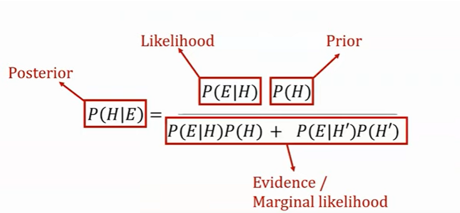

Where:
- $ P(H|E) $ is the posterior probability of event H given evidence B.
- $ P(E|H) $ is the likelihood of observing evidence E given that event H has occurred.
- $ P(H) $ is the prior probability of event H, our initial belief before considering the evidence.
- $ P(E) $ is the probability of observing evidence E, the marginal likelihood.

Bayes' Theorem enables us to update our beliefs in a principled way as we gather more information or evidence.

Positives:
- Information efficient (good with small samples)
- Prior can be incorporated
- Informs about uncertainty
- Interpretable
- Flexible

Negatives:
- Computationally intensive
- Can be sensitive to prior

In [116]:
import random
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az

# Biased coin example

Alice and Bob are playing a simple game:
- there is a biased coin, with an *unknown bias* x. (p: probability of head)
- when a head comes up Alice gets a point
- when a tail comes up Bob gets a point
- first to reach 6 points wins

Assume that at some point Alice has 5 points and Bob has 3. The question is: **What is the probability that Bob wins?**

$P(\text{Bob wins}|a=5, b=3) = \frac{P(a=5, b=3|\text{Bob wins}) \cdot P(\text{Bob wins})}{P(a=5, b=3)}$

## Calculation

1. Denominator (What is the probability of getting 5 heads and 3 tails with a coin with unknown bias?)

    $P(a=5, b=3) = \int_{0}^{1} {8 \choose 3} x^3 (1-x)^5  dx = \frac{1}{9}$

2. Numerator (What is the probability of both reaching the status 5:3 and Bob winning?)

    $P(a=5, b=3|\text{Bob wins}) P(\text{Bob wins}) = \int_{0}^{1} {8 \choose 3} x^3 (1-x)^5 x^3 dx = \frac{1}{99}$

Final answer:

$P(\text{Bob wins}|a=5, b=3) = \frac{1}{99} / \frac{1}{9} \approx 0.091$

## Small example simulation

In [69]:
def do_simulation(num_rows, n, k):
    # Create the first column with random values of the probability x between 0 and 1
    # This is the probability that Bob wins any given point
    x_values = np.random.rand(num_rows, 1)

    # The associated probabilities that the status of A:5 & B:3 is reached 
    # (pmf: the probability that a discrete random variable is exactly equal to some value)
    prob_a5_b3 = np.array([stats.binom.pmf(k, n, x) for x in x_values])

    # Was the status actually reached?
    random_values_1 = np.random.rand(num_rows, 1)
    a5_b3_reached = np.array(random_values_1 < prob_a5_b3)

    # Probability of Bob winning from 5:3, 0 otherwise
    prob_b_wins = np.array([np.array([0]) if not reached else x*x*x  for reached, x in zip(a5_b3_reached,x_values)])

    # Did Bob actually win  from 5:3? 0 otherwise
    random_values_2 = np.random.rand(num_rows, 1)
    b_won = np.array(random_values_2 < prob_b_wins)


    # Put it in a DataFrame
    result_array = np.hstack((x_values, prob_a5_b3, random_values_1, a5_b3_reached, \
                              prob_b_wins, random_values_2, b_won))

    results_df = pd.DataFrame(result_array, columns=['Bias of coin','Prob. of reaching 5:3',
                                        'Random value 1','Was 5:3 reached',
                                        'Prob. Bob wins from 5:3','Random value 2', 
                                        'Has Bob won from 5:3'])
    

    return results_df

# Define a custom styling function
def color_rows(row):
    # print(val)
    # print()
    # Define your color criteria here
    if row['Was 5:3 reached'] == 1 and row['Has Bob won from 5:3'] == 1:
        return [None, None, None, 'background-color: green', None, None, 'background-color: green']
    elif row['Was 5:3 reached'] == 1 and row['Has Bob won from 5:3'] == 0:
        return [None, None, None, 'background-color: yellow', None, None, 'background-color: yellow']
    else:
        return [None, None, None, 'background-color: grey', None, None, 'background-color: grey']



In [44]:
# Number of rows
num_rows = 30
k=3
n=8

results_df = do_simulation(num_rows, n, k)
f = {col:'{:.2f}' for col in results_df.columns} 
# Apply the styling function to the DataFrame
results_df.style.format(f).apply(color_rows, axis=1)

,Bias of coin,Prob. of reaching 5:3,Random value 1,Was 5:3 reached,Prob. Bob wins from 5:3,Random value 2,Has Bob won from 5:3
0,0.30,0.26,0.09,1.00,0.03,0.04,0.00
1,0.25,0.21,0.35,0.00,0.00,0.67,0.00
2,0.07,0.01,0.06,0.00,0.00,0.88,0.00
3,0.74,0.03,0.08,0.00,0.00,0.41,0.00
4,0.29,0.24,0.28,0.00,0.00,0.80,0.00
5,0.11,0.04,0.75,0.00,0.00,0.90,0.00
6,0.04,0.00,0.86,0.00,0.00,0.65,0.00
7,0.99,0.00,0.60,0.00,0.00,0.46,0.00
8,0.62,0.11,0.70,0.00,0.00,0.64,0.00
9,0.62,0.11,0.01,1.00,0.24,0.11,1.00


## Large sample
Take a larger sample and calculate in how many of 
the cases where 5:3 was reached Bob ended up winning.

In [70]:
# Number of samples
num_rows = 50000
# State of game parameters
k=3
n=8

results_df = do_simulation(num_rows, n, k)

filtered_df = results_df[results_df['Was 5:3 reached']==1]
result = filtered_df['Has Bob won from 5:3'].sum()/filtered_df['Has Bob won from 5:3'].size
print(f"Approximation of the probability that Bob wins from 5:3 from a simulation with a sample size of 50000:\nP(Bob wins|a=5, b=3) ~ {result:.4f}")

Approximation of the probability that Bob wins from 5:3 from a simulation with a sample size of 50000:
P(Bob wins|a=5, b=3) ~ 0.0903


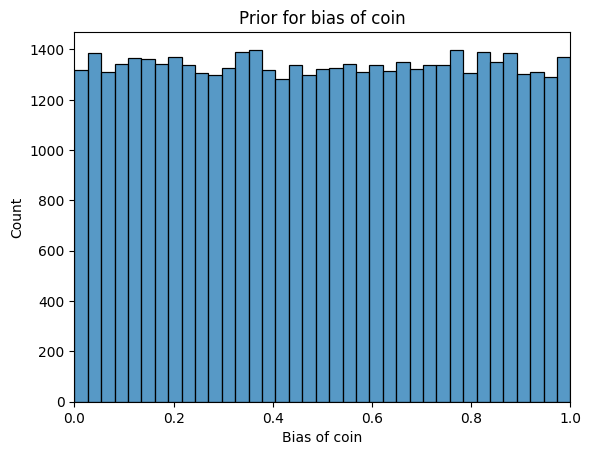

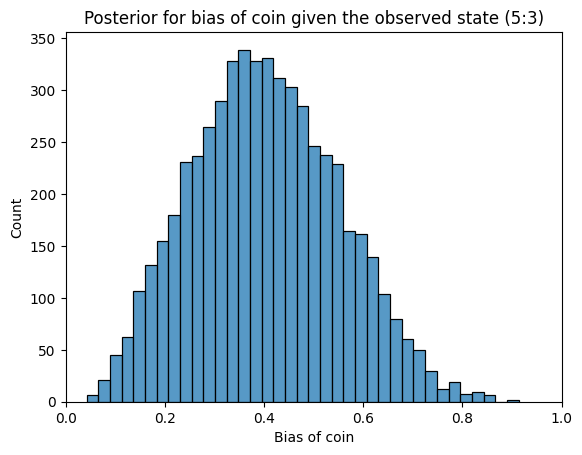

In [71]:
# We could check the distributions of other variables, for example 

# the uniform distribution of the bias of coin, x:
sns.histplot(results_df[results_df['Has Bob won from 5:3']==0]['Bias of coin'], discrete=False)
plt.xlim(0,1)
plt.title('Prior for bias of coin')
plt.show()

# the bias of coin (probability that Bob wins a single point) in the cases where 5:3 was reached
sns.histplot(filtered_df['Bias of coin'], discrete=False)
plt.title('Posterior for bias of coin given the observed state (5:3)')
plt.xlim(0,1)
plt.show()

## Pymc3 solution for the same problem

In [86]:
# Define the initial scores for Alice and Bob
observed_data = [1,1,1, 0,0,0,0,0]

# Create a PyMC3 model
with pm.Model() as model:
    # Define the probability of heads (bias of the coin) as a uniform prior
    x = pm.Uniform('x', 0, 1)
    
    # Define the observed data using a Bernoulli distribution
    observed = pm.Bernoulli('observed', p=x, observed=observed_data)
    
    
#     # Alternative way:
#     # Define the likelihood of Alice winning a game
#     next_3_flips = pm.Binomial('next_3_flips', n=3, p=x)
#     print(next_3_flips.tag.test_value)

#     # Estimate the probability of Bob winning
#     # bob_wins = ('bob_wins', next_3_flips==3)
#     bob_wins = pm.Deterministic("bob_wins", next_3_flips>2)

    # Estimate the probability of Bob winning
    p_bob_wins3 = pm.Deterministic("p_bob_wins3", x*x*x)
    

# Perform the inference
with model:
    trace = pm.sample(100000, tune=1000, cores=2, random_seed=123)

# Calculate the estimated probability that Bob wins
estimated_prob_bob_wins3 = trace['p_bob_wins3'].mean()

print(f"Estimated probability that Bob wins: {estimated_prob_bob_wins3:.3f}")

# print(f"Estimated probability that Bob wins: {trace['bob_wins'].mean():.3f}")

/opt/conda/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 108 seconds.


Estimated probability that Bob wins: 0.091


**We get the same answer as from the calculation and the simulation**, but arguably much easier.

<AxesSubplot:ylabel='Percent'>

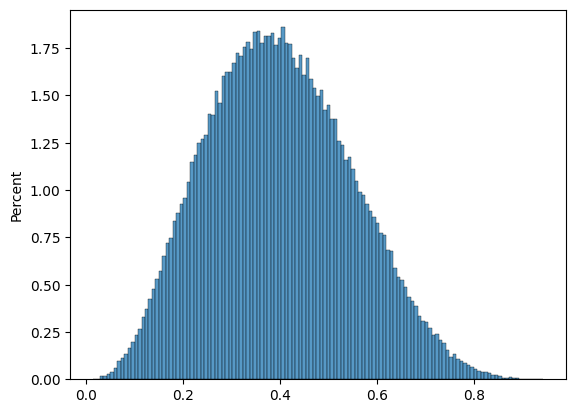

In [87]:
sns.histplot(trace.x, stat='percent', discrete=False)

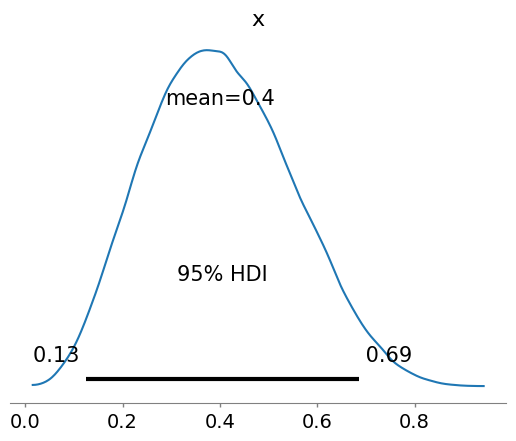

In [88]:
az.plot_posterior(trace['x'], hdi_prob=0.95)
plt.show()

95% HDI (credible interval): there is a 95% probability that the true (unknown) estimate would lie within the interval, given the evidence provided by the observed data.

# A/B testing

A/B testing is similar. Say, we reached 5:3, and with another coin reached 4:4 from 8 flips. This is all we know about the coins. How sure should Bob be that he is better off playing with the second coin? A crucial point is not to compare the posteriors for the two coins, but to look at the posterior distribution of the differences. 

The most common application is comparing the success rates of different marketing strategies (or clickthroughs).

The example uses different synthetic data (from https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb).

In [99]:
#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 2000
N_B = 1250

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] ...


In [100]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.0455
0.0392


In [101]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # Do the sampling
    step = pm.Metropolis()
    trace = pm.sample(50000, step=step)
    burned_trace=trace[1000:]

/opt/conda/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [102]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

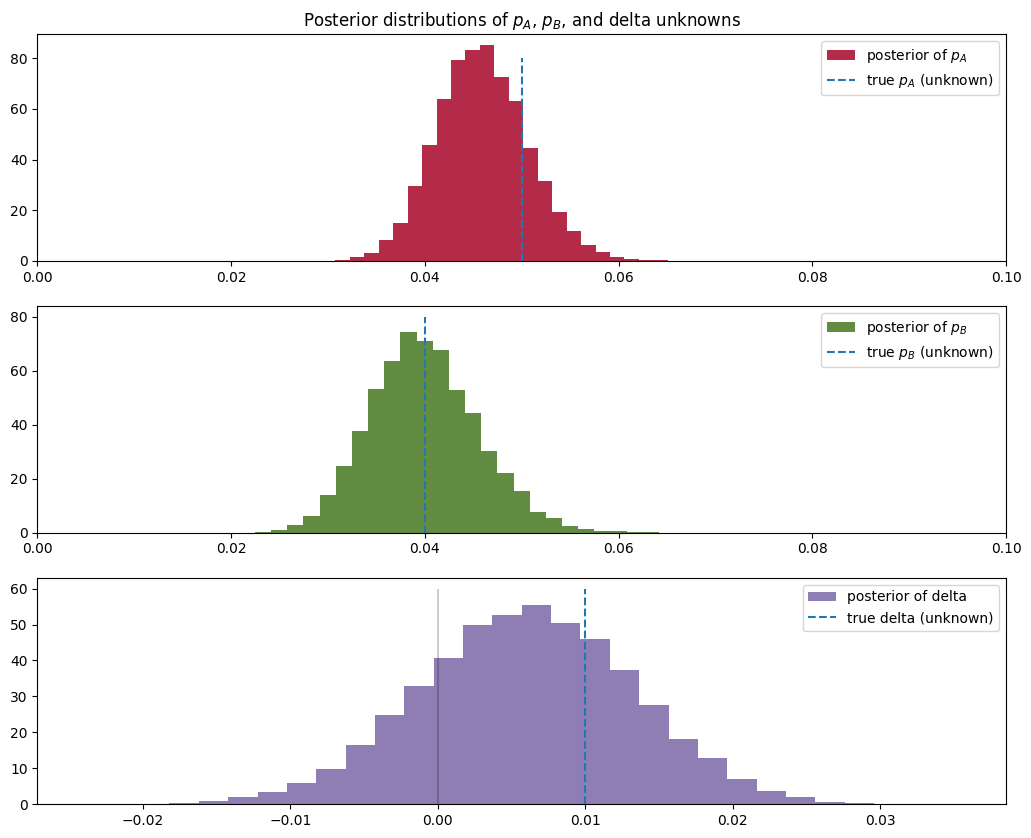

In [104]:
fig, axes = plt.subplots(3,1,figsize=(12.5, 10))

#histogram of posteriors

ax = axes[0]

ax.set_xlim(0, .1)
ax.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
ax.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
ax.legend(loc="upper right")
ax.set_title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = axes[1]

ax.set_xlim(0, .1)
ax.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
ax.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
ax.legend(loc="upper right")

ax = axes[2]
ax.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
ax.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
ax.vlines(0, 0, 60, color="black", alpha=0.2)
ax.legend(loc="upper right");

<AxesSubplot:title={'center':'x'}>

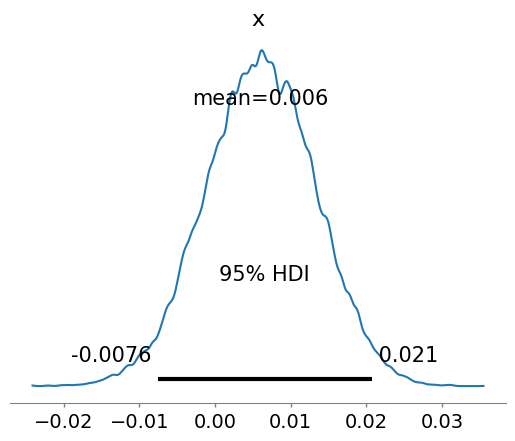

In [109]:
az.plot_posterior(trace['delta'], hdi_prob=0.95)

In [105]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.203
Probability site A is BETTER than site B: 0.797


An example of a trace:

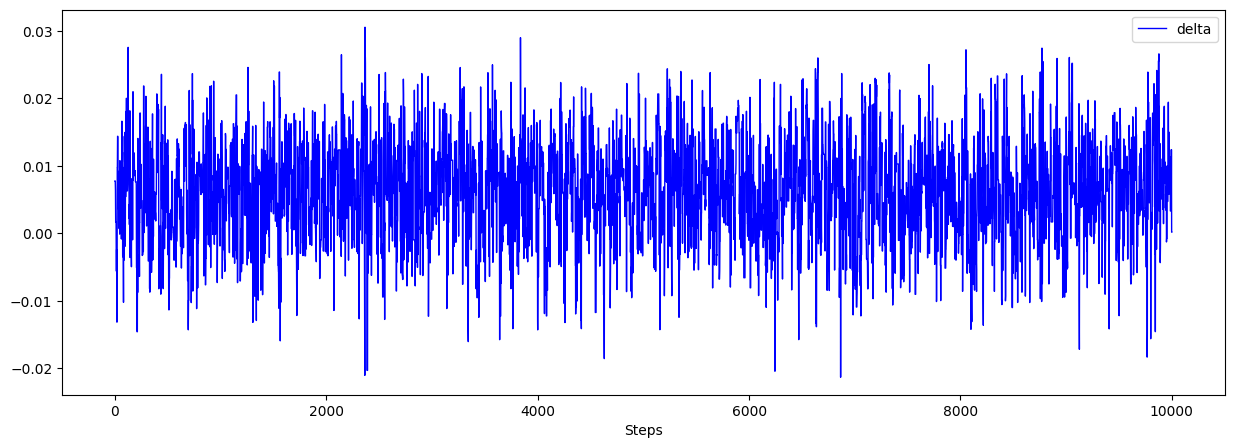

In [114]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(trace['delta'][:10000], label="delta",
     color='b', lw=1)
plt.xlabel("Steps")
plt.legend();

More details including prior predictive checks:
https://www.pymc.io/projects/examples/en/latest/case_studies/bayesian_ab_testing_introduction.html

# Appendix

- Application examples (potential topics for future sessions):
    - Probabilistic Search and Record Linkage (Arinze's notebooks): https://gitlab.agile.nat.bt.com/DCU/knowledge-sharing-sessions/-/tree/main/2023.07.11.search_and_linkage_in_high_dimensions
    - Bayesian logistic regression (and model selection with WAIC): https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/generalized_linear_models/GLM-logistic.html
    - Hierarchical linear regression: https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html
    - Bayesian optimisation: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiguvfxipOBAxWqWUEAHTGSDYsQwqsBegQIDhAF&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DDGJTEBt0d-s&usg=AOvVaw2DQwAfnSbK2qcE9ub_ED9-&opi=89978449
    - Bayesian missing data imputation: https://www.pymc.io/projects/examples/en/latest/case_studies/Missing_Data_Imputation.html
                            https://num.pyro.ai/en/stable/tutorials/bayesian_imputation.html
    - Anomaly detection: https://www.bayesserver.com/docs/techniques/anomaly-detection/
                        https://cdn.aaai.org/ocs/15527/15527-68720-1-PB.pdf
    - Web analitycs
    - Element of search in AB testing
    

# Resources:
    - Books:
        https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/
        http://allendowney.github.io/ThinkBayes2/chap05.html
        https://statswithr.github.io/book/
        http://aprsa.villanova.edu/files/sivia.pdf
        https://xcelab.net/rm/statistical-rethinking/ (also youtube lectures)
        https://vasishth.github.io/bayescogsci/book/
    - Videos (for beginners):
        https://www.youtube.com/watch?v=3OJEae7Qb_o&ab_channel=rasmusab
        https://www.youtube.com/watch?v=NIqeFYUhSzU&t=49s&ab_channel=WoodyLewenstein
    - Wrapping a bayesian model as an sklearn model (video) 
        https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj3_JKuipOBAxXRiVwKHafiAUYQwqsBegQIEBAF&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DzGRnirbHWJ8&usg=AOvVaw0b7OWuUsuGJCPyRrKz9Fs3&opi=89978449
    - PYMC3 Tutorials:
        https://www.pymc.io/projects/examples/en/latest/howto/api_quickstart.html
        https://www.pymc.io/projects/examples/en/latest/blog/category/tutorial.html
    - R packeges:
        stan https://mc-stan.org/
        rjags http://mcmc-jags.sourceforge.net/
        bayesrules https://cran.r-project.org/web/packages/bayesrules/index.html
    - Other:
        MCMC sampling for dummies: https://twiecki.io/blog/2015/11/10/mcmc-sampling/